In [1]:
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt

In [2]:
class Circuit: 
    '''

    Class for that generates N-dimensional gates acting of arbitatry qubit.
    Gates - Pauli Rotation, H, X, RY, RX, RZ and CNOT.
    Also generates the zero N-dimensional state.

    '''

    def __init__(self, nqubits):
        self.nqubits = nqubits
        self.σx = np.array([[0.0,1.0],[1.0,0.0]]);
        self.σz = np.array([[1.0,0.0],[0.0,-1.0]]);
        self.σy = np.array([[0.0,-1j],[1.j,0.0]]);
        self.σ = np.array([np.eye(2), self.σx, self.σy, self.σz]);
        self.d = 2**nqubits
        self.H = np.array([[1,1],[1,-1]])/np.sqrt(2.0)

    def zero_state(self):
        ψ = np.zeros((self.d,))
        ψ[0] = 1.0
        return ψ

    def pauli_rotation(self, state, σ, θ, qubit):
        θ = np.asarray(θ).reshape(-1,1,1)/2.0
        M = θ.shape[0]
        U = np.cos(θ) * np.eye(2) - 1j * np.sin(θ) * σ
        Usame = U[:,[0,1],[0,1]].reshape(-1,2)
        Uoppo = U[:,[0,1],[1,0]].reshape(-1,2)
        di = 2**qubit
        dj = 2**(self.nqubits - qubit - 1)
        state = state.reshape(-1, dj, 2, di)
        state = Usame.reshape(M, 1, 2, 1) * state \
              + Uoppo.reshape(M, 1, 2, 1) * state[:, :, [1,0], :]
        if state.shape[0] == 1:
            return state.flatten()
        else:
            return state.reshape(-1, self.d)

    def h(self, state, qubit):
        di = 2**qubit
        s = state.shape
        state = state.reshape(-1, 2, di)
        return np.einsum('mjl,ji->mil', state, self.H).reshape(s)

    def x(self, state, qubit):
        di = 2**qubit
        s = state.shape
        state = state.reshape(-1, 2, di)
        return state[:,[1,0],:].reshape(s)

    def ry(self, state, θ, qubit):
        return self.pauli_rotation(state, self.σy, θ, qubit)

    def rx(self, state, θ, qubit):
        return self.pauli_rotation(state, self.σx, θ, qubit)

    def rz(self, state, θ, qubit):
        return self.pauli_rotation(state, self.σz, θ, qubit)

    def cx(self, state, qubit, target):
        assert self.nqubits >= 2
        assert 0 <= qubit <= self.nqubits
        assert 0 <= target <= self.nqubits
        assert target != qubit
        i = min(qubit, target)
        j = max(qubit, target)
        di = 2**i
        dj = 2**(j-i-1)
        dk = 2**(self.nqubits - j - 1)
        s = state.shape
        state = state.reshape(-1, 2, dj, 2, di).copy()
        if qubit > target:
            state[:,1,:,[1,0],:] = state[:,1,:,[0,1],:]
        else:
            state[:,[1,0],:,1,:] = state[:,[0,1],:,1,:]
        return state.reshape(s)


In [3]:
from numpy import pi as π
def coding_bits(b):
    c = [b[n:n+5] for n,i in enumerate(b) if n%5==0]
    c_p=[]
    coding_0=[]
    for i in range(len(c)):
        for j in c[i]:
            c_p.append(str(j))
    np.asarray(c_p)
    c = [c_p[n:n+5] for n,i in enumerate(c_p) if n%5==0]
    for i in c:
        coding_0.append(''.join(i))
    return coding_0

class CircuitConversor:
    
    '''
    ## Decodes strings of bits into a an array representating the state.
    __call__ function takes in a string of bits and returns the state and the cost to apply operations.
    '''

    def __init__(self, nqubits, nparameters):
        self.gates = gates = {}
        for n, suffix in enumerate(['00','01','10','11']):
            angle = π / (2**n)
            gates['000'+suffix] = (self.make_h(), 1.0)
            gates['001'+suffix] = (self.make_cx(), 2.0)
            gates['010'+suffix] = (self.make_id(), 0.0)
            gates['011'+suffix] = (self.make_rx(angle), 1.0)
            gates['100'+suffix] = (self.make_rz(angle), 1.0)
            gates['101'+suffix] = (self.make_id(), 0.0)
            gates['110'+suffix] = (self.make_id(), 0.0)
            gates['111'+suffix] = (self.make_ry(angle), 1.0)
        self.nqubits = nqubits
        self.nparameters = nparameters
        self.circuit = Circuit(nqubits)

    def __call__(self, coding_0, parameters):
        k = 0
        cost = 0
        state = self.circuit.zero_state()
        for ndx, z in enumerate(coding_bits(coding_0)):
            qubit = ndx % self.nqubits
            target = (ndx + 1) % self.nqubits
            fn, weight = self.gates[z]
            state, k = fn(state, parameters, k, qubit, target)
            cost += weight
        if k == 0 and parameters.ndim == 2:
            state = np.ones((parameters.shape[1],1)) * state.reshape(1,-1)
        return state, cost

    def make_id(self):
        def operation(state, parameters, k, qubit, target):
            return state, k
        return operation

    def make_h(self):
        def operation(state, parameters, k, qubit, target):
            return self.circuit.h(state, qubit), k
        return operation

    def make_cx(self):
        def operation(state, parameters, k, qubit, target):
            return self.circuit.cx(state, qubit, target), k
        return operation

    def make_rx(self, angle):
        def operation(state, parameters, k, qubit, target):
            ndx = k % self.nparameters
            return self.circuit.rx(state, parameters[ndx,:]*angle, qubit), k+1
        return operation

    def make_ry(self, angle):
        def operation(state, parameters, k, qubit, target):
            ndx = k % self.nparameters
            return self.circuit.ry(state, parameters[ndx,:]*angle, qubit), k+1
        return operation

    def make_rz(self, angle):
        def operation(state, parameters, k, qubit, target):
            ndx = k % self.nparameters
            return self.circuit.rz(state, parameters[ndx,:]*angle, qubit), k+1
        return operation


In [4]:
from sklearn.svm import SVC

class QSVM:
    '''
    Takes in the feature map we generated and outputs a classifier model and its fit.
    '''
    def __init__(self, feature_map, train_features, train_label):
        def kernel(x1, x2):
            ψ1 = feature_map(x1.T)
            ψ2 = feature_map(x2.T)
            gram = ψ1.real @ ψ2.real.T + ψ1.imag @ ψ2.imag.T
            return gram
        self.svc = SVC(kernel=kernel)
        self.svc.fit(train_features, train_label)

    def run(self):
        pass

    def predict(self, dataset_features):
        return self.svc.predict(dataset_features)


In [5]:
import os
import psutil
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import accuracy_score

def metricas_modelos(y_true, y_pred): 
    from sklearn.metrics import accuracy_score
    accuracy = accuracy_score(y_true, y_pred)
    return(accuracy)

def reca(y_true, y_pred):
    from sklearn.metrics import recall_score
    recall = recall_score(y_true,y_pred,average='binary')
    return(recall)

def Dataset(X, y, test_size_split=0.2):
    class_labels = [r'0', r'1']

    n_samples = np.shape(X)[0]
    training_size = int(n_samples-(n_samples*test_size_split))
    test_size =int(n_samples-training_size)
    train_sample, test_sample, train_label, test_label = \
        train_test_split(X, y, stratify=y, test_size=test_size_split, random_state=12)

    std_scale = StandardScaler().fit(train_sample)
    train_sample = std_scale.transform(train_sample)
    test_sample = std_scale.transform(test_sample)

    samples = np.append(train_sample, test_sample, axis=0)
    minmax_scale = MinMaxScaler((-1, 1)).fit(samples)
    train_sample = minmax_scale.transform(train_sample)
    test_sample = minmax_scale.transform(test_sample)

    return train_sample, train_label, test_sample, test_label

class Fitness:
    '''
    This class calculates the fitness of a single bit string and return its cost and accuracy 
    '''

    def __init__(self, nqubits, nparameters, X, y, debug=False):
        self.nqubits = nqubits
        self.nparameters = nparameters
        self.cc = CircuitConversor(nqubits, nparameters)
        self.X = X
        self.y = y
        self.debug = debug

    def __call__(self, POP):
        return self.fitness(POP)

    def fitness(self, POP):
        #Convertimos el individuo en el fenotipo (ansatz)
        training_features, training_labels, test_features, test_labels = \
            Dataset(self.X, self.y)
        
        model = QSVM(lambda parameters: self.cc(POP, parameters)[0],
                          training_features, training_labels)
        y_pred = model.predict(test_features) # 22% del computo (ver abajo line-profiler)
        acc = metricas_modelos(test_labels, y_pred) # sklearn
        rec = reca(test_labels,y_pred)
        POP=''.join(str(i) for i in POP)
        _, gates = self.cc(POP, training_features[:,[0,1]])
        if self.debug:
            print(f'String: {POP}\n -> accuracy = {acc}, gates = {gates},recall = {rec}')
        gate = gates/self.nqubits
        wc = gate + (gate*(acc**2))
        return wc, acc


In [6]:
from deap import base, creator, tools, algorithms
import random
def gsvm(nqubits, depth, nparameters, X, y,
         mu=100, lambda_=150, cxpb=0.7, mutpb=0.3, ngen=2000,
         use_pareto=True, verbose=True, weights=[-1.0,1.0],
         debug=True):
    bits_puerta = 5
    long_cadena = depth * nqubits * bits_puerta
    creator.create("FitnessMulti", base.Fitness, weights=weights)
    creator.create("Individual", list, fitness = creator.FitnessMulti, statistics=dict)

    toolbox = base.Toolbox()
    toolbox.register("attr_bool", random.randint, 0, 1)
    toolbox.register("Individual", tools.initRepeat, creator.Individual,
                     toolbox.attr_bool, long_cadena)
    toolbox.register("Population", tools.initRepeat, list, toolbox.Individual)
    toolbox.register('mate', tools.cxTwoPoint)
    toolbox.register('mutate', tools.mutFlipBit, indpb=0.2)
    toolbox.register('select', tools.selNSGA2)
    toolbox.register("evaluate", Fitness(nqubits, nparameters, X, y, debug=debug))

    pop = toolbox.Population(n=mu)

    stats_wc = tools.Statistics(key=lambda ind: ind.fitness.values[0])
    stats_wc.register('media',np.mean)
    stats_wc.register('std',np.std)
    stats_wc.register('max',np.max)
    stats_wc.register('min',np.min)
    stats_acc = tools.Statistics(key=lambda ind: ind.fitness.values[1])
    stats_acc.register('media',np.mean)
    stats_acc.register('std',np.std)
    stats_acc.register('max',np.max)
    stats_acc.register('min',np.min)
    mstats = tools.MultiStatistics(wc=stats_wc, acc=stats_acc)

    logbook = tools.Logbook()
    pareto = tools.ParetoFront(similar = np.array_equal)
    pop, logbook = algorithms.eaMuPlusLambda(pop, toolbox,
                                             mu, lambda_, cxpb, mutpb, ngen,
                                             stats=mstats,
                                             halloffame=pareto, verbose=verbose)
    pareto.update(pop)
    return pop, pareto, logbook


In [7]:
output="bank_testdata.csv"
df = pd.read_csv('bank_cleaned.csv')  

bank_data = df.sample(n=2000)

In [23]:
nqubits = 8
depth = 10
y = bank_data['y'].values
X = bank_data[['age','job','marital','education','default','balance','housing','loan','contact',
                'day','month','duration','campaign','pdays','previous','poutcome']].values
start = time.time()

pop, pareto, logbook = gsvm(nqubits=nqubits, depth=depth, nparameters=16,
                                    X=X, y=y, weights=[-1.0,1.0],
                                    mu=20,lambda_=10,ngen=20,mutpb=0.3,cxpb=.7)

print(f'Simulation finished after {time.time()-start} seconds')

with open(output, "w") as f:
    for ide, ind in enumerate(pareto):
        genes=''.join(str(i) for i in list(ind))
        gates, acc = ind.fitness.values
        line = f'{ide},"{genes}",{gates},{acc}'
        f.write(line)
        f.write('\n')

d:\Anaconda\envs\qc\lib\site-packages\deap\creator.py:138: RuntimeWarning: A class named 'FitnessMulti' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
d:\Anaconda\envs\qc\lib\site-packages\deap\creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


String: 1101011111101100111101000011111010010000011101010110100110000000000000001111010011011100011011011001110010110101101101100100111110010100000011101111110101100010110010100100001111010111001010100110111111101001010011101111011111001000011110011011011110011111101111011111111101100101111000000110101110011000011110000010010111000011001100101010000001100101011101111001010100101001111010001101111011000000
 -> accuracy = 0.7525, gates = 49.0,recall = 0.7397959183673469
String: 1101100010110001011101011010010110110100011001000110011110011110001100001000001010011010100111110000111110110111110111001010111111111001111110000110111110110111000000011101011100111000001001011010011101001100000011010100111101001101011000011011010000101111011001011111111111010001000001100000110110110100101110000100011101011100101000011111010011101100000001001110101011001000010011001110110110001010
 -> accuracy = 0.7275, gates = 59.0,recall = 0.6989795918367347
String: 0001111011100000010101110001100000101000010111

In [26]:
iot_result = pd.read_csv('bank_testdata.csv',header=None)

def ordenar_salidas_pareto(dataframe):
    dataframe.columns=['ind','circ','gates','accuracy']
    dataframe.sort_values(['gates','accuracy'], ascending=[False,False],inplace=True)
    dataframe.reset_index(inplace=True)
    dataframe.pop('index')
    return dataframe

iot_salidas = ordenar_salidas_pareto(iot_result)
iot_salidas # Queremos ver el primer circuito del dataframe yya ordenado por accuracy (mejor ind)

,ind,circ,gates,accuracy
0,13,0011000101000001100110011111111110101010001110...,11.915850,0.8200
1,12,0110011000110000100010111111111110101010001110...,10.843991,0.8175
2,11,0110011000110000100010111111111110101010001110...,10.791016,0.8125
3,10,1101011111101100111101000011111000111110010001...,10.150625,0.7900
4,9,0100001000001110100110100110011000111110010001...,8.867684,0.7825
5,8,0110011000110000100010111111111000111110010001...,8.222845,0.7525
6,7,1101011111101100111101000011111000111110010001...,7.793781,0.7475
7,6,0110011000110000100010111111111000111110010001...,7.538281,0.7125
8,5,0110011000110000100010111111111000111110010001...,7.297997,0.7050
9,4,0110011000110000100010111111111000111110010001...,7.229747,0.6950


['00110', '00101', '00000', '11001', '10011', '11111', '11101', '01010', '00111', '01101', '00100', '11100', '10111', '11010', '01001', '11111', '00110', '00010', '00110', '10001', '10011', '10111', '11001', '10110', '11000', '11111', '10110', '11111', '01011', '00101', '01010', '10100', '00111', '10110', '10011', '11000', '00110', '11100', '10100', '01010', '11101', '00000', '00100', '00011', '10101', '01000', '10100', '01000', '01010', '00010', '11011', '10010', '01011', '01001', '10000', '00110', '00011', '10100', '01110', '00001', '11101', '10110', '01001', '10011', '11101', '11010', '11000', '00101', '11111', '11010', '01100', '11100', '11110', '10110', '10101', '00001', '11010', '01101', '00010', '10100']
57.0


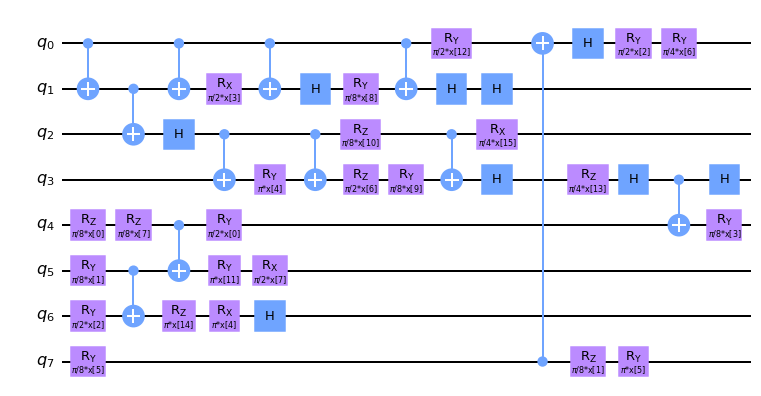

In [27]:
from qiskit.circuit import ParameterVector, QuantumCircuit
from qiskit import QuantumRegister

class CircuitConversor2:

    def __init__(self, nqubits, nparameters):
        gates = {}
        for n, suffix in enumerate(['00','01','10','11']):
            angle = np.pi / (2**n)
            gates['000'+suffix] = (self.make_H(), 1.0)
            gates['001'+suffix] = (self.make_cx(), 2.0)
            gates['010'+suffix] = (self.make_id(), 0.0)
            gates['011'+suffix] = (self.make_rx(angle), 1.0)
            gates['100'+suffix] = (self.make_rz(angle), 1.0)
            gates['101'+suffix] = (self.make_id(), 0.0)
            gates['110'+suffix] = (self.make_id(), 0.0)
            gates['111'+suffix] = (self.make_ry(angle), 1.0)
        self.gates = gates
        self.nqubits = nqubits
        self.register = QuantumRegister(nqubits, 'q')
        self.nparameters = nparameters
        self.nqubits = nqubits
        self.x = ParameterVector('x', nparameters)

    def __call__(self, coding_0):
        print(coding_0)
        circuit = QuantumCircuit(self.register)
        k = 0
        cost = 0
        for ndx, z in enumerate(coding_0):
            qubit = ndx % self.nqubits
            target = (ndx + 1) % self.nqubits
            fn, weight = self.gates[z]
            k = fn(circuit, k, qubit, target)
            cost += weight
        for i in range(k, self.nparameters):
            circuit.rz(self.x[i]*0, self.register[0])
        return circuit, cost

    def make_id(self):
        def operation(circuit, k, qubit, target):
            return k
        return operation

    def make_H(self):
        def operation(circuit, k, qubit, target):
            circuit.h(self.register[qubit])
            return k
        return operation

    def make_cx(self):
        def operation(circuit, k, qubit, target):
            circuit.cx(self.register[qubit], self.register[target])
            return k
        return operation

    def make_rx(self, angle):
        def operation(circuit, k, qubit, target):
            circuit.rx(self.x[k%self.nparameters] * angle,
                       self.register[qubit])
            return k+1
        return operation

    def make_ry(self, angle):
        def operation(circuit, k, qubit, target):
            circuit.ry(self.x[k%self.nparameters] * angle,
                       self.register[qubit])
            return k+1
        return operation

    def make_rz(self, angle):
        def operation(circuit, k, qubit, target):
            circuit.rz(self.x[k%self.nparameters] * angle,
                       self.register[qubit])
            return k+1
        return operation

cc = CircuitConversor2(nqubits=nqubits, nparameters=16)
fm, puertas = cc(coding_bits(iot_salidas.circ[0]))
print(puertas)
fm.draw(output='mpl')

In [19]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, recall_score, accuracy_score
import matplotlib.pyplot as plt

In [24]:
def featuremap_performance(pop:str,nqubits:int) -> None:
    '''Returns the performance of a feature map on all of the dataset'''
    df_1 = df.sample(frac=1)

    for i in range(8):
        if i == 7:
            bank_data = df_1.iloc[60000:79844]
            break
        bank_data = df_1.iloc[i*10000:i*10000+10000]

        y = bank_data['y'].values
        X = bank_data[['age','job','marital','education','default','balance',
                    'housing','loan','contact','day','month','duration','campaign','pdays','previous','poutcome']].values


        fitness_obj = Fitness(nqubits,16,X,y,debug=True)

        training_features, training_labels, test_features, test_labels = Dataset(X,y)

        model = QSVM(lambda parameters: fitness_obj.cc(pop, parameters)[0],training_features,training_labels)#fitness_obj(pop)

        y_pred = model.predict(test_features)

        cm = confusion_matrix(test_labels, y_pred)

        #cm_display = ConfusionMatrixDisplay(cm).plot()
        ConfusionMatrixDisplay.from_predictions(test_labels, y_pred)
        plt.show()
        recall = recall_score(test_labels, y_pred)
        acc  = accuracy_score(test_labels, y_pred)

        print(f'String = {pop},\n accuracy = {acc}, recall = {recall} for {i+1}th section of the data')
        
    return None


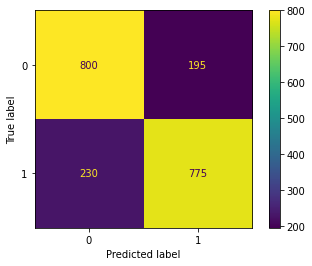

String = 0011000101000001100110011111111110101010001110110100100111001011111010010011111100110000100011010001100111011111001101101100011111101101111101011001010101010100001111011010011110000011011100101000101011101000000010000011101010100010100010000101000010110111001001011010011000000110000111010001110000011110110110010011001111101110101100000101111111101001100111001111010110101010000111010011010001010100,
 accuracy = 0.7875, recall = 0.7711442786069652 for 1th section of the data


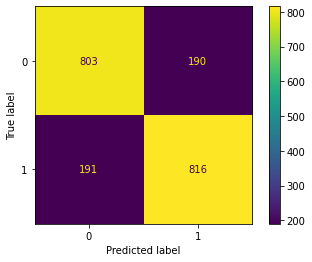

String = 0011000101000001100110011111111110101010001110110100100111001011111010010011111100110000100011010001100111011111001101101100011111101101111101011001010101010100001111011010011110000011011100101000101011101000000010000011101010100010100010000101000010110111001001011010011000000110000111010001110000011110110110010011001111101110101100000101111111101001100111001111010110101010000111010011010001010100,
 accuracy = 0.8095, recall = 0.8103277060575969 for 2th section of the data


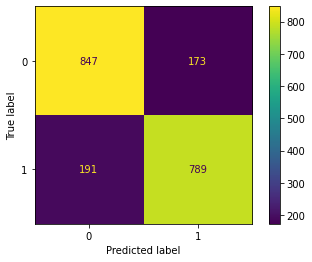

String = 0011000101000001100110011111111110101010001110110100100111001011111010010011111100110000100011010001100111011111001101101100011111101101111101011001010101010100001111011010011110000011011100101000101011101000000010000011101010100010100010000101000010110111001001011010011000000110000111010001110000011110110110010011001111101110101100000101111111101001100111001111010110101010000111010011010001010100,
 accuracy = 0.818, recall = 0.8051020408163265 for 3th section of the data


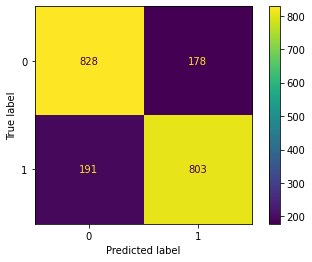

String = 0011000101000001100110011111111110101010001110110100100111001011111010010011111100110000100011010001100111011111001101101100011111101101111101011001010101010100001111011010011110000011011100101000101011101000000010000011101010100010100010000101000010110111001001011010011000000110000111010001110000011110110110010011001111101110101100000101111111101001100111001111010110101010000111010011010001010100,
 accuracy = 0.8155, recall = 0.8078470824949698 for 4th section of the data


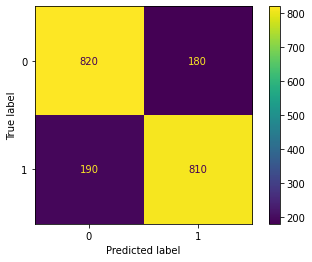

String = 0011000101000001100110011111111110101010001110110100100111001011111010010011111100110000100011010001100111011111001101101100011111101101111101011001010101010100001111011010011110000011011100101000101011101000000010000011101010100010100010000101000010110111001001011010011000000110000111010001110000011110110110010011001111101110101100000101111111101001100111001111010110101010000111010011010001010100,
 accuracy = 0.815, recall = 0.81 for 5th section of the data


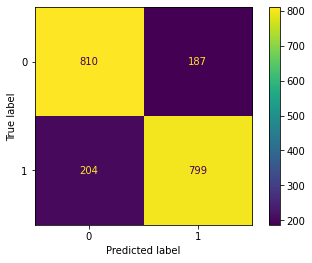

String = 0011000101000001100110011111111110101010001110110100100111001011111010010011111100110000100011010001100111011111001101101100011111101101111101011001010101010100001111011010011110000011011100101000101011101000000010000011101010100010100010000101000010110111001001011010011000000110000111010001110000011110110110010011001111101110101100000101111111101001100111001111010110101010000111010011010001010100,
 accuracy = 0.8045, recall = 0.7966101694915254 for 6th section of the data


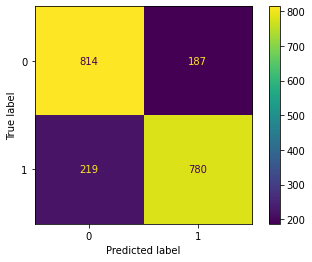

String = 0011000101000001100110011111111110101010001110110100100111001011111010010011111100110000100011010001100111011111001101101100011111101101111101011001010101010100001111011010011110000011011100101000101011101000000010000011101010100010100010000101000010110111001001011010011000000110000111010001110000011110110110010011001111101110101100000101111111101001100111001111010110101010000111010011010001010100,
 accuracy = 0.797, recall = 0.7807807807807807 for 7th section of the data


In [30]:
featuremap_performance(iot_salidas.circ[0],nqubits)

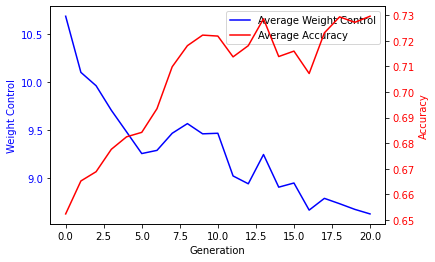

<Figure size 600x400 with 0 Axes>

In [29]:
gen = logbook.select("gen")
wc = logbook.chapters["wc"].select("media")
acc = logbook.chapters["acc"].select("media")

import matplotlib.pyplot as plt

fig, ax1 = plt.subplots()
plt.figure(dpi = 100)
line1 = ax1.plot(gen, wc ,"b-", label="Average Weight Control")
ax1.set_xlabel("Generation")
ax1.set_ylabel("Weight Control", color="b")
for tl in ax1.get_yticklabels():
    tl.set_color("b")

ax2 = ax1.twinx()
line2 = ax2.plot(gen, acc, "r-", label="Average Accuracy")
ax2.set_ylabel("Accuracy", color="r")
for tl in ax2.get_yticklabels():
    tl.set_color("r")

lns = line1 + line2
labs = [l.get_label() for l in lns]
ax1.legend(lns, labs, loc="best")

plt.show()